In [1]:
import tsplib95
from tsplib95 import utils
from tsplib95 import distances
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt
import functools
import math
import pandas as pd
import itertools

## Import dos problemas

In [2]:
problem1 = tsplib95.load('ch130.tsp')

In [3]:
problem1.as_name_dict();

In [4]:
problem2 = tsplib95.load('tsp225.tsp')

In [5]:
problem2.as_name_dict();

## Implementação do Algoritmo

o algoritmo base foi retirado deste site, https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35 , porém eu fiz várias alterações

In [6]:
def euclidean(start, end, round=utils.nint):

    if len(start) != len(end):
        raise ValueError('dimension mismatch between start and end')

    square_distance = sum(d * d for d in utils.deltas(start, end))
    distance = math.sqrt(square_distance)

    return round(distance)

In [7]:
def geographical(start, end, round=utils.nint, radius=6378.388):

    if len(start) != len(end):
        raise ValueError('dimension mismatch between start and end')

    start = utils.RadianGeo(start)
    end = utils.RadianGeo(end)

    q1 = math.cos(start.lng - end.lng)
    q2 = math.cos(start.lat - end.lat)
    q3 = math.cos(start.lat + end.lat)
    distance = radius * math.acos(0.5 * ((1 + q1) * q2 - (1 - q1) * q3)) + 1

    return round(distance)

In [11]:
class City:                         #definir a classe cidade
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city, dist_func="euclidean"):    #a distaância pode ser euclidiana ou geográfica. Implementei a distância geográfica porque inicialmente um dos benchmarks escolhidos tinha a solução ótima com a distância geográfica. No entanto, depois modificamos os benchmarks mas decidi deixar ficar.
        if dist_func=="euclidean":
            return euclidean((self.x,self.y),(city.x,city.y))
        elif dist_func =="geographical":
            return geographical((self.x,self.y),(city.x,city.y))
        else:
            print("dist_func not implemented")
    
    def __repr__(self):                                      #cada cidade é representada por um tuplo (x,y)
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [12]:
class Fitness:                 #definir a classe fitness 
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self, dist_func):        #função que calcula a distância de cada caminho/tour
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):    #o len(route) é o número de cidades que tem na route
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]     #como a route está representada pelo path representation, é só calcular a distância entre cada cidade e somar tudo
                else:
                    toCity = self.route[0]
                
                pathDistance += fromCity.distance(toCity,dist_func) #somamos a distância cidade a cidade
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self, dist_func):        #função que define o fitness de cada indivíduo, que é o inverso da distância. 
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance(dist_func))
        return self.fitness

In [13]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))  #quando criamos uma route inicial, é random. por isso, combinamos as cidades de forma aleatória
    return route

In [14]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))   #uma population é um conjunto de routes. por isso, inicialmente criamos várias routes(soluções) aleatórias ("à toa"), que em conjunto vão formar uma população
    return population

In [15]:
def rankRoutes(population, dist_func):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness(dist_func) #para cada elemento da população, temos de calcular o seu fitness, que diz o quão boa é uma solução/caminho. O que é retornado são as soluções por ordem decrescente de fitness
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [16]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()  #percentagens/probabilidade atribuida a cada individuo 
    
    for i in range(0, eliteSize): #mantemos os elementos elite
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize): #depois de garantirmos a elite, temos (população - elite) lugares para preencher.  
        pick = 100*random.random() #probabilidade aleatoria para escolher route com base na sua probabilidade/fitness
        for i in range(0, len(popRanked)):  #como os elementos da elite já estão na população, agora queremos escolher os outros lugares aleatoriamente. Estes lugares vão ser lugares que vão passar por crossover depois. 
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break   #quando um if for corrido, retornamos ao primeiro for.
    return selectionResults

In [17]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index]) #criar a população
    return matingpool

In [18]:
def breed(parent1, parent2, cross_func="order"): #Order, Cycle e Partially mapped crossover
    child = []
    childP1 = []
    childP2 = []
    
    
    geneA, geneB=np.random.choice(len(parent1), 2,  replace=False) #geramos dois genes (inicial e final) de forma random. estes genes vão de 0 até len(population)-1, pois indicam a posição
 
    
    #fazer a subtour
    startGene = min(geneA, geneB) 
    endGene = max(geneA, geneB)

    if cross_func=="order": #order crossover
        childP1 = parent1[startGene:endGene+1]   #extraímos a subtour resultante do parent1 
        childP2 = [item for item in parent2 if item not in childP1] #os elementos do parent2 que nao se encontram na subtour extraida do parent1, são identificados
        child = childP2[:startGene] + childP1 + childP2[startGene:]  #juntamos os elementos do parent 2 com a subtour do parent 1, pela mesma ordem que se encontram no parent 2
        
    elif cross_func=="cycle": #cycle crossover
        child=[-1]*len(parent1)  #Criamos uma lista só com "-1", porque não há nenhuma cidade "-1". este número é só para identificar as posições.
        child[0]=[parent1[0]]  #a primeira posição do novo individuo é a primeira posição do parent 1
        h1=0
        
        while parent2[h1] not in child:  
            h2=parent1.index(parent2[h1])  #explicado no relatorio. 
            child[h2]=parent2[h1]
            h1=h2
        
        for i in range(0,len(child)):
            if child[i]==-1:             #quando o while anterior atinge uma cidade que já se encontra no indivíduo filho, as restantes posições do indivíduo filho (marcados por "-1" ) são preenchidas pelos elementos do parent 2 nessas posições.
                child[i]=parent2[i]
    
    elif cross_func=="partial":  #tentei implementar o partial mas não está a dar certo
        child=[-1]*len(parent1)
        childP1 = parent1[startGene:endGene+1]
        child = child[:startGene] + childP1 + child[endGene+1:]
        hi=[]
        hp2=[]
        for i in range(startGene,endGene+1):
            if parent2[i] not in child:
                hi.append(parent2[i])
                hp2.append(parent2.index(parent1[i]))

        for i in hp2:
            if child[i]!=-1:
                hp2[hp2.index(i)]=parent2.index(child[i])
    

        for i in hp2:
            child[i]=hi.pop(0)
    
        for i in range(0,len(child)):
            if child[i]==-1:
                child[i]=parent2[i]

 
    return child


In [19]:
def breedPopulation(matingpool, eliteSize, cross_func):  #construir a população resultante do crossover
    children = []
    length = len(matingpool) - eliteSize  # os individuos que vao sofrer crossover são len(matingpool)-eliteSize, logo também vamos ter o mesmo número de filhos. 
    pool = random.sample(matingpool, len(matingpool))  #para os elementos do elite nao ficarem todos no inicio da lista onde tem os individuos que sofrem crossover, esta lista é "reordenada".
    for i in range(0,eliteSize):
        children.append(matingpool[i]) #garantimos os individuos elite
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1], cross_func)  #os restantes individuos da população sao adquiridos por crossover
        children.append(child)
    return children

In [20]:
def mutate(individual, mutationRate, mut_func="swap"): #Swap, Invert, Insert and Displacement mutations
    if(random.random() < mutationRate):     #nem todos os indivíduos sofrem mutação. por isso, a mutação só é realizada se o número random que se gerar for inferior à mutationRate
        city1_ind, city2_ind=np.random.choice(len(individual), 2,  replace=False)
        city1 = individual[city1_ind]
        city2 = individual[city2_ind]
        if mut_func=="swap":   #swap mutation
            individual[city1_ind] = city2
            individual[city2_ind] = city1
        elif mut_func =="invert":  #invert mutation - inverter uma subtour 
            if city2_ind < city1_ind:
                city1_ind, city2_ind = city2_ind, city1_ind
            if city1_ind == 0:
                individual=individual[:city1_ind]+individual[city2_ind:city1_ind:-1]+[individual[city1_ind]]+individual[city2_ind+1::]
            else:
                individual = individual[:city1_ind]+individual[city2_ind:city1_ind-1:-1]+individual[city2_ind+1::]
        elif mut_func =="insert": #insert mutation
            individual=individual[:city1_ind]+individual[city1_ind+1:] #tiramos uma cidade de um sitio
            individual.insert(random.randint(0, len(individual)), city1) #metemos essa cidade noutra posição
        elif mut_func =="disp": #displacement mutation
            if city2_ind < city1_ind:
                city1_ind, city2_ind = city2_ind, city1_ind
            if city1_ind==0 and city2_ind==len(individual)-1:  #se as cidades das pontas forem as pontas do individuo, o individuo permanece igual
                return individual
            
            subt=individual[city1_ind:city2_ind+1] #subtour que vai mudar de posição
            individual=individual[:city1_ind]+individual[city2_ind+1:] #tirar a subtour 
            c=np.random.choice(len(individual)) #escolher uma posição pra meter a subtour
            individual[c:c] = subt  #meter a subtour noutra posição (c)
            
        else:
            print("mut_func not implemented")

    return individual

In [21]:
def mutatePopulation(population, mutationRate, mut_func): #população resultante da mutação
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate, mut_func) #mutar cada individuo 1 a 1 com uma certa mutationRate
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [22]:
def nextGeneration(currentGen, eliteSize, mutationRate, dist_func,  mut_func, cross_func):  #definir a próxima população
    popRanked = rankRoutes(currentGen, dist_func)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize, cross_func)
    nextGeneration = mutatePopulation(children, mutationRate, mut_func)
    return nextGeneration

In [ ]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations, stop_crit, dist_func, mut_func, cross_func): #Stop_crit < generations
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop, dist_func)[0][1]))
    oldRoutecost = rankRoutes(pop, dist_func)[0][1]
    progress = []
    progress.append(1 / rankRoutes(pop, dist_func)[0][1])
    counter=0
    final_iter = generations
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate, dist_func, mut_func, cross_func)
        bestRouteIndex, bestcost = rankRoutes(pop, dist_func)[0]
        bestRoute = pop[bestRouteIndex]
        if bestcost > oldRoutecost:
            counter=0
        else:
            counter=counter+1
        if counter > stop_crit:
            print("Stopped after", i," Iterations")
            final_iter= i
            break
        progress.append(1 / bestcost)
        oldRoutecost = bestcost
    
    #print("Best distance: " , min(progress))
    bestRouteIndex = rankRoutes(pop, dist_func)[0][0]
    bestRoute = pop[bestRouteIndex]
    #print("Best route: " , bestRoute)
    
    #PLot Progress
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()
    
    return min(progress) , final_iter

In [25]:
cityListp1 = []

for i in range(1,131):
    cityListp1.append(City(x=int(problem1.node_coords[i][0]), y=int(problem1.node_coords[i][1])))

In [26]:
cityListp2 = []

for i in range(1,226):
    cityListp2.append(City(x=int(problem2.node_coords[i][0]), y=int(problem2.node_coords[i][1])))

In [27]:
#correr n vezes e fazer a média. retorna um tuplo (time, distância, nr de iterações que fez se parou mais cedo) (tudo em média)
import time
import statistics

def geneticAlgorithm_média(n, population, popSize, eliteSize, mutationRate, generations, stop_crit, dist_func, mut_func, cross_func): 
    timelist=[]
    solutionlist=[]
    iter_list = []
    for i in range(0,n):
        start = time.time()
        h, fin_iter =geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations, stop_crit, dist_func, mut_func, cross_func)
        end = time.time()
        timelist.append(end - start)
        solutionlist.append(h)
        iter_list.append(fin_iter)


    mean_time = statistics.mean(timelist)
    mean_solution = statistics.mean(solutionlist)
    mean_iter = statistics.mean(iter_list)
    return mean_time, mean_solution, mean_iter

Initial distance: 42722.0
Best distance:  24983.0
Best route:  [(444,384), (526,409), (30,450), (32,345), (169,245), (220,623), (288,667), (598,446), (599,361), (678,410), (561,357), (417,341), (370,332), (264,377), (543,481), (614,418), (566,199), (568,287), (687,373), (698,348), (521,132), (415,78), (689,167), (530,183), (567,352), (519,347), (478,509), (361,564), (169,547), (295,664), (456,597), (133,677), (24,500), (657,39), (503,172), (416,227), (384,87), (143,92), (63,23), (214,43), (311,2), (6,23), (40,187), (29,330), (32,448), (40,424), (177,295), (269,295), (470,309), (571,375), (683,414), (454,537), (51,676), (397,262), (575,141), (426,61), (638,62), (554,279), (403,205), (469,281), (399,170), (91,148), (196,221), (370,151), (280,5), (484,49), (572,373), (635,200), (504,240), (509,435), (209,691), (662,549), (489,665), (252,535), (263,426), (224,358), (178,104), (238,33), (42,63), (84,183), (97,211), (434,92), (526,215), (535,471), (415,479), (282,329), (27,424), (252,535), (

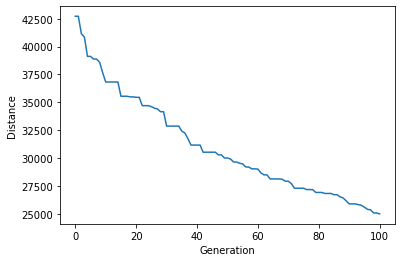

(18.542478799819946, 24983.0, 100)

In [427]:
#correr 5 vezes e fazer a média
geneticAlgorithm_média(5, population=cityListp1, popSize=100, eliteSize=25, mutationRate=0.01, generations=100, stop_crit=10,  mut_func="disp", dist_func="euclidean", cross_func="order")

Initial distance: 42336.0
Best distance:  20559.0
Best route:  [(51,676), (16,656), (209,691), (265,684), (489,665), (662,549), (526,409), (478,509), (415,479), (282,329), (248,343), (535,471), (598,446), (568,287), (614,418), (567,352), (519,347), (399,156), (416,227), (334,161), (97,211), (280,5), (355,76), (403,205), (698,348), (676,371), (238,33), (178,104), (6,23), (220,409), (206,437), (140,513), (21,660), (133,677), (335,660), (295,664), (280,458), (224,358), (263,426), (213,525), (252,535), (252,535), (543,481), (692,543), (635,200), (637,54), (488,3), (426,61), (384,87), (450,126), (554,279), (504,240), (264,377), (145,399), (29,330), (240,430), (370,332), (319,626), (444,384), (678,410), (683,414), (687,373), (469,281), (397,262), (32,448), (27,424), (129,435), (259,454), (603,134), (521,132), (415,78), (526,215), (453,282), (214,43), (84,31), (42,63), (63,23), (268,52), (311,2), (441,299), (417,341), (470,309), (599,361), (689,167), (638,62), (572,373), (561,357), (571,375),

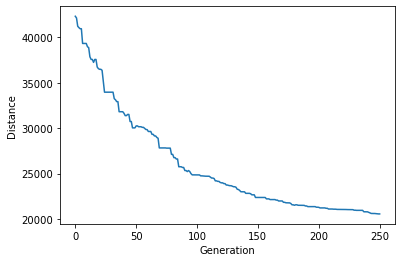

(20559.0, 250)

In [425]:
geneticAlgorithm(population=cityListp1, popSize=80, eliteSize=30, mutationRate=0.1, generations=250, stop_crit=10, mut_func="swap",dist_func="euclidean", cross_func="order")

In [28]:
population_size=[80, 150, 300]
elite_size=[30,60]
mutation_rate=[0.0001,0.001,0.01,0.1]
mutation_type=["swap", "invert", "insert", "disp"]
crossover_type=["order", "cycle"]

In [29]:
combos=list(itertools.product(population_size,elite_size,mutation_rate, mutation_type, crossover_type))
len(combos)

192

In [31]:
#tenho a função geneticAlgorithm_média que me retorna (tempo, distancia)
import numpy as np
h1=[]
for i in range(len(combos)):
    sol=geneticAlgorithm_média(5, population=cityListp1, popSize=combos[i][0], eliteSize=combos[i][1], mutationRate=combos[i][2], generations=250, stop_crit=10,  mut_func=combos[i][3], dist_func="euclidean", cross_func=combos[i][4])
    h1.append([x for x in combos[i]]+ [x for x in sol ])
np.savetxt("resultsGAp1.csv", 
           h1,
           delimiter =", ", 
           fmt ='% s')

Initial distance: 41813.0
Stopped after 74  Iterations
Initial distance: 42694.0
Stopped after 116  Iterations
Initial distance: 43353.0
Stopped after 174  Iterations
Initial distance: 42196.0
Stopped after 125  Iterations
Initial distance: 42140.0
Stopped after 109  Iterations
Initial distance: 43672.0
Stopped after 31  Iterations
Initial distance: 41757.0
Stopped after 22  Iterations
Initial distance: 42385.0
Stopped after 32  Iterations
Initial distance: 43540.0
Stopped after 27  Iterations
Initial distance: 42512.0
Stopped after 30  Iterations
Initial distance: 42926.0
Stopped after 129  Iterations
Initial distance: 41316.0
Stopped after 115  Iterations
Initial distance: 41697.0
Stopped after 104  Iterations
Initial distance: 43323.0
Stopped after 109  Iterations
Initial distance: 41737.0
Stopped after 119  Iterations
Initial distance: 42643.0
Stopped after 28  Iterations
Initial distance: 42483.0
Stopped after 36  Iterations
Initial distance: 42551.0
Stopped after 38  Iterations
I

Stopped after 44  Iterations
Initial distance: 42990.0
Stopped after 13  Iterations
Initial distance: 43363.0
Stopped after 53  Iterations
Initial distance: 42696.0
Stopped after 48  Iterations
Initial distance: 42489.0
Stopped after 15  Iterations
Initial distance: 40849.0
Stopped after 127  Iterations
Initial distance: 42540.0
Stopped after 63  Iterations
Initial distance: 43128.0
Initial distance: 42672.0
Stopped after 34  Iterations
Initial distance: 40445.0
Stopped after 31  Iterations
Initial distance: 42502.0
Stopped after 22  Iterations
Initial distance: 39872.0
Stopped after 10  Iterations
Initial distance: 42614.0
Stopped after 54  Iterations
Initial distance: 43177.0
Stopped after 54  Iterations
Initial distance: 42108.0
Stopped after 20  Iterations
Initial distance: 42132.0
Stopped after 25  Iterations
Initial distance: 42033.0
Stopped after 111  Iterations
Initial distance: 43398.0
Stopped after 100  Iterations
Initial distance: 41988.0
Stopped after 111  Iterations
Initia

Stopped after 15  Iterations
Initial distance: 42235.0
Stopped after 131  Iterations
Initial distance: 42043.0
Stopped after 57  Iterations
Initial distance: 42097.0
Stopped after 116  Iterations
Initial distance: 41054.0
Stopped after 130  Iterations
Initial distance: 41957.0
Stopped after 128  Iterations
Initial distance: 41460.0
Stopped after 177  Iterations
Initial distance: 41712.0
Stopped after 118  Iterations
Initial distance: 42367.0
Stopped after 27  Iterations
Initial distance: 41030.0
Stopped after 39  Iterations
Initial distance: 41053.0
Stopped after 35  Iterations
Initial distance: 41911.0
Stopped after 35  Iterations
Initial distance: 42015.0
Stopped after 30  Iterations
Initial distance: 42389.0
Stopped after 166  Iterations
Initial distance: 41238.0
Stopped after 120  Iterations
Initial distance: 42281.0
Stopped after 117  Iterations
Initial distance: 42796.0
Stopped after 116  Iterations
Initial distance: 42733.0
Stopped after 136  Iterations
Initial distance: 42484.0

Stopped after 227  Iterations
Initial distance: 41101.0
Stopped after 176  Iterations
Initial distance: 42134.0
Stopped after 163  Iterations
Initial distance: 42291.0
Stopped after 83  Iterations
Initial distance: 39896.0
Stopped after 32  Iterations
Initial distance: 41371.0
Stopped after 36  Iterations
Initial distance: 42360.0
Stopped after 30  Iterations
Initial distance: 41876.0
Stopped after 42  Iterations
Initial distance: 41587.0
Stopped after 39  Iterations
Initial distance: 41159.0
Stopped after 145  Iterations
Initial distance: 41903.0
Stopped after 159  Iterations
Initial distance: 42131.0
Stopped after 140  Iterations
Initial distance: 42906.0
Stopped after 162  Iterations
Initial distance: 41032.0
Stopped after 166  Iterations
Initial distance: 42345.0
Stopped after 38  Iterations
Initial distance: 40323.0
Stopped after 40  Iterations
Initial distance: 41691.0
Stopped after 45  Iterations
Initial distance: 41628.0
Stopped after 43  Iterations
Initial distance: 42285.0
St

Stopped after 195  Iterations
Initial distance: 42505.0
Stopped after 226  Iterations
Initial distance: 41307.0
Stopped after 158  Iterations
Initial distance: 41071.0
Stopped after 46  Iterations
Initial distance: 41173.0
Stopped after 42  Iterations
Initial distance: 41179.0
Stopped after 48  Iterations
Initial distance: 41764.0
Stopped after 43  Iterations
Initial distance: 41975.0
Stopped after 45  Iterations
Initial distance: 40396.0
Stopped after 173  Iterations
Initial distance: 41435.0
Stopped after 177  Iterations
Initial distance: 41032.0
Stopped after 179  Iterations
Initial distance: 41498.0
Stopped after 164  Iterations
Initial distance: 39973.0
Stopped after 154  Iterations
Initial distance: 40878.0
Stopped after 52  Iterations
Initial distance: 41853.0
Stopped after 54  Iterations
Initial distance: 41686.0
Stopped after 40  Iterations
Initial distance: 40720.0
Stopped after 42  Iterations
Initial distance: 40846.0
Stopped after 67  Iterations
Initial distance: 41601.0
St

Stopped after 75  Iterations
Initial distance: 41354.0
Stopped after 74  Iterations
Initial distance: 41570.0
Stopped after 178  Iterations
Initial distance: 41741.0
Stopped after 146  Iterations
Initial distance: 41845.0
Stopped after 165  Iterations
Initial distance: 40873.0
Stopped after 42  Iterations
Initial distance: 40109.0
Stopped after 50  Iterations
Initial distance: 42267.0
Stopped after 59  Iterations
Initial distance: 41592.0
Stopped after 44  Iterations
Initial distance: 41419.0
Stopped after 49  Iterations
Initial distance: 41713.0
Stopped after 212  Iterations
Initial distance: 41663.0
Stopped after 166  Iterations
Initial distance: 42165.0
Stopped after 203  Iterations
Initial distance: 41009.0
Stopped after 203  Iterations
Initial distance: 42712.0
Initial distance: 42258.0
Stopped after 46  Iterations
Initial distance: 41183.0
Stopped after 53  Iterations
Initial distance: 41969.0
Stopped after 55  Iterations
Initial distance: 40726.0
Stopped after 53  Iterations
Ini

In [32]:
#tenho a função geneticAlgorithm_média que me retorna (tempo, distancia)

h2=[]
for i in range(len(combos)):
    sol=geneticAlgorithm_média(5, population=cityListp2, popSize=combos[i][0], eliteSize=combos[i][1], mutationRate=combos[i][2], generations=250, stop_crit=10,  mut_func=combos[i][3], dist_func="euclidean", cross_func=combos[i][4])
    h2.append([x for x in combos[i]]+ [x for x in sol ])
np.savetxt("resultsGAp2.csv", 
           h2,
           delimiter =", ", 
           fmt ='% s')

Initial distance: 39338.0
Stopped after 110  Iterations
Initial distance: 37921.0
Stopped after 139  Iterations
Initial distance: 36754.0
Stopped after 161  Iterations
Initial distance: 38432.0
Stopped after 139  Iterations
Initial distance: 38748.0
Stopped after 162  Iterations
Initial distance: 37416.0
Stopped after 35  Iterations
Initial distance: 39017.0
Stopped after 26  Iterations
Initial distance: 37865.0
Stopped after 27  Iterations
Initial distance: 38800.0
Stopped after 36  Iterations
Initial distance: 37489.0
Stopped after 39  Iterations
Initial distance: 38264.0
Stopped after 118  Iterations
Initial distance: 39005.0
Stopped after 114  Iterations
Initial distance: 37745.0
Stopped after 120  Iterations
Initial distance: 37985.0
Stopped after 116  Iterations
Initial distance: 38048.0
Stopped after 129  Iterations
Initial distance: 37587.0
Stopped after 28  Iterations
Initial distance: 38636.0
Stopped after 28  Iterations
Initial distance: 38829.0
Stopped after 34  Iterations


Stopped after 84  Iterations
Initial distance: 38863.0
Stopped after 42  Iterations
Initial distance: 37537.0
Stopped after 51  Iterations
Initial distance: 38810.0
Stopped after 12  Iterations
Initial distance: 37616.0
Stopped after 52  Iterations
Initial distance: 38583.0
Stopped after 18  Iterations
Initial distance: 36924.0
Stopped after 19  Iterations
Initial distance: 38472.0
Stopped after 64  Iterations
Initial distance: 38412.0
Stopped after 41  Iterations
Initial distance: 38551.0
Stopped after 59  Iterations
Initial distance: 38035.0
Stopped after 71  Iterations
Initial distance: 38719.0
Stopped after 80  Iterations
Initial distance: 37894.0
Stopped after 86  Iterations
Initial distance: 38692.0
Stopped after 57  Iterations
Initial distance: 38427.0
Stopped after 49  Iterations
Initial distance: 37934.0
Stopped after 11  Iterations
Initial distance: 38607.0
Stopped after 15  Iterations
Initial distance: 38555.0
Stopped after 39  Iterations
Initial distance: 38827.0
Stopped af

Stopped after 156  Iterations
Initial distance: 37442.0
Stopped after 39  Iterations
Initial distance: 38650.0
Stopped after 47  Iterations
Initial distance: 38478.0
Stopped after 47  Iterations
Initial distance: 38709.0
Stopped after 49  Iterations
Initial distance: 37306.0
Stopped after 40  Iterations
Initial distance: 38026.0
Stopped after 169  Iterations
Initial distance: 37493.0
Stopped after 139  Iterations
Initial distance: 38462.0
Stopped after 169  Iterations
Initial distance: 38202.0
Stopped after 187  Iterations
Initial distance: 37594.0
Stopped after 129  Iterations
Initial distance: 37748.0
Stopped after 29  Iterations
Initial distance: 37800.0
Stopped after 32  Iterations
Initial distance: 37908.0
Stopped after 27  Iterations
Initial distance: 37872.0
Stopped after 45  Iterations
Initial distance: 36544.0
Stopped after 23  Iterations
Initial distance: 38638.0
Stopped after 189  Iterations
Initial distance: 38445.0
Stopped after 165  Iterations
Initial distance: 37733.0
St

Stopped after 122  Iterations
Initial distance: 36303.0
Stopped after 191  Iterations
Initial distance: 38662.0
Stopped after 35  Iterations
Initial distance: 37579.0
Stopped after 43  Iterations
Initial distance: 38845.0
Stopped after 41  Iterations
Initial distance: 38375.0
Stopped after 49  Iterations
Initial distance: 38743.0
Stopped after 49  Iterations
Initial distance: 38645.0
Stopped after 197  Iterations
Initial distance: 37531.0
Initial distance: 37935.0
Stopped after 228  Iterations
Initial distance: 37965.0
Stopped after 204  Iterations
Initial distance: 38571.0
Stopped after 224  Iterations
Initial distance: 37711.0
Stopped after 36  Iterations
Initial distance: 38462.0
Stopped after 48  Iterations
Initial distance: 39108.0
Stopped after 44  Iterations
Initial distance: 37271.0
Stopped after 50  Iterations
Initial distance: 38764.0
Stopped after 38  Iterations
Initial distance: 37681.0
Stopped after 218  Iterations
Initial distance: 36632.0
Stopped after 231  Iterations
In

Initial distance: 38497.0
Stopped after 58  Iterations
Initial distance: 37366.0
Stopped after 61  Iterations
Initial distance: 37455.0
Stopped after 50  Iterations
Initial distance: 37581.0
Stopped after 55  Iterations
Initial distance: 37018.0
Stopped after 62  Iterations
Initial distance: 37985.0
Initial distance: 38206.0
Initial distance: 37879.0
Initial distance: 37665.0
Initial distance: 37242.0
Initial distance: 36732.0
Stopped after 51  Iterations
Initial distance: 37899.0
Stopped after 59  Iterations
Initial distance: 38741.0
Stopped after 70  Iterations
Initial distance: 38179.0
Stopped after 66  Iterations
Initial distance: 37394.0
Stopped after 41  Iterations
Initial distance: 37411.0
Initial distance: 37991.0
Stopped after 242  Iterations
Initial distance: 37884.0
Initial distance: 37869.0
Initial distance: 37471.0
Initial distance: 37812.0
Stopped after 56  Iterations
Initial distance: 38149.0
Stopped after 58  Iterations
Initial distance: 37952.0
Stopped after 64  Iterat

Stopped after 42  Iterations
Initial distance: 38035.0
Stopped after 65  Iterations
Initial distance: 37990.0
Stopped after 41  Iterations
Initial distance: 37784.0
Initial distance: 38539.0
Initial distance: 37693.0
Initial distance: 38614.0
Initial distance: 38238.0
Initial distance: 37407.0
Stopped after 138  Iterations
Initial distance: 38285.0
Stopped after 53  Iterations
Initial distance: 38057.0
Stopped after 216  Iterations
Initial distance: 36655.0
Initial distance: 38015.0
Stopped after 146  Iterations
Initial distance: 38097.0
Initial distance: 37625.0
Initial distance: 37733.0
Initial distance: 37465.0
Initial distance: 37938.0
Initial distance: 37406.0
Initial distance: 37711.0
Initial distance: 38289.0
Initial distance: 38055.0
Initial distance: 38319.0
Initial distance: 38126.0
Initial distance: 37735.0
Initial distance: 38534.0
Initial distance: 37992.0
Initial distance: 37774.0
Initial distance: 38229.0
Initial distance: 38098.0
Stopped after 112  Iterations
Initial di

### The data analysis will be performed in a new notebook - GA_DataAnalysis

## After the Data Analysis

Para o Problema 1, os melhores parametros foram -> elite size 30, mutation_rate de 10% ou mais, population_size de 300 ou mais, order crossover, invert mutation. numero de generations maior.

Para o Problema 2, os melhores parametros foram -> elite size 30, mutation_rate de 10% ou mais, population_size de 300 ou mais, order crossover, disp mutation. numero de generations maior.

In [75]:
def geneticAlgorithm2(population, popSize, eliteSize, mutationRate, generations, stop_crit, dist_func, mut_func, cross_func): #Stop_crit < generations
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop, dist_func)[0][1]))
    oldRoutecost = rankRoutes(pop, dist_func)[0][1]
    progress = []
    timee = []
    progress.append(1 / rankRoutes(pop, dist_func)[0][1])
    timee.append(0)
    counter=0
    final_iter = generations
    for i in range(0, generations):
        start = time.time()
        pop = nextGeneration(pop, eliteSize, mutationRate, dist_func, mut_func, cross_func)
        bestRouteIndex, bestcost = rankRoutes(pop, dist_func)[0]
        bestRoute = pop[bestRouteIndex]
        if bestcost > oldRoutecost:
            counter=0
        else:
            counter=counter+1
        if counter > stop_crit:
            print("Stopped after", i," Iterations")
            final_iter= i
            break
        end = time.time()
        progress.append(1 / bestcost)
        timee.append(end - start)
        oldRoutecost = bestcost
    
    #print("Best distance: " , min(progress))
    bestRouteIndex = rankRoutes(pop, dist_func)[0][0]
    bestRoute = pop[bestRouteIndex]
    #print("Best route: " , bestRoute)
    
    #PLot Progress
    #plt.plot(progress)
    #plt.ylabel('Distance')
    #plt.xlabel('Generation')
    #plt.show()
    
    
    return min(progress) , final_iter, progress, timee

In [78]:
def geneticAlgorithm_média2(n, population, popSize, eliteSize, mutationRate, generations, stop_crit, dist_func, mut_func, cross_func): 
    timelist=[]
    solutionlist=[]
    iter_list = []
    progress_list = []
    time_list =[]
    for i in range(0,n):
        start = time.time()
        h, fin_iter, progress, timee =geneticAlgorithm2(population, popSize, eliteSize, mutationRate, generations, stop_crit, dist_func, mut_func, cross_func)
        end = time.time()
        timelist.append(end - start)
        solutionlist.append(h)
        iter_list.append(fin_iter)
        progress_list.append(progress)
        time_list.append(timee)


    mean_time = statistics.mean(timelist)
    mean_solution = statistics.mean(solutionlist)
    mean_iter = statistics.mean(iter_list)
    mean_progress = [(g1 + g2 + g3 + g4 + g5) / n for g1, g2, g3, g4, g5 in zip(progress_list[0], progress_list[1], progress_list[2], progress_list[3], progress_list[4])]
    mean_timee = [(g1 + g2 + g3 + g4 + g5) / n for g1, g2, g3, g4, g5 in zip(time_list[0], time_list[1], time_list[2], time_list[3], time_list[4])]
    return mean_time, mean_solution, mean_iter, mean_progress, mean_timee

### Problem 1 _ Repeated

In [ ]:
population_size=[300, 500, 1000]
elite_size=[30, 60]
mutation_rate=[0.01, 0.1, 0.20, 0.30]
mutation_type=["invert"]
crossover_type=["order"]
combos_2=list(itertools.product(population_size,elite_size,mutation_rate, mutation_type, crossover_type))
import numpy as np
h1_3=[]
for i in range(len(combos_2)):
    sol=geneticAlgorithm_média2(5, population=cityListp1, popSize=combos_2[i][0], eliteSize=combos_2[i][1], mutationRate=combos_2[i][2], generations=2000, stop_crit=10,  mut_func=combos_2[i][3], dist_func="euclidean", cross_func=combos_2[i][4])
    h1_3.append([x for x in combos_2[i]]+ [x for x in sol ])
np.savetxt("resultsGAp1_2.csv", 
           h1_3,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
population_size=[300, 500]
elite_size=[30]
mutation_rate=[0.01, 0.1]
mutation_type=["disp"]
crossover_type=["order"]
combos_2=list(itertools.product(population_size,elite_size,mutation_rate, mutation_type, crossover_type))
import numpy as np
h1_4=[]
for i in range(len(combos_2)):
    sol=geneticAlgorithm_média2(5, population=cityListp2, popSize=combos_2[i][0], eliteSize=combos_2[i][1], mutationRate=combos_2[i][2], generations=2000, stop_crit=10,  mut_func=combos_2[i][3], dist_func="euclidean", cross_func=combos_2[i][4])
    h1_4.append([x for x in combos_2[i]]+ [x for x in sol ])
np.savetxt("resultsGAp2_2.csv", 
           h1_4,
           delimiter =", ", 
           fmt ='% s')

# Problema 1 - Análise

In [144]:
#distância mínima encontrada
min(h1_3, key=lambda x: x[6])[6]

10075.2

Text(0.5, 1.0, 'Distance evolution with time')

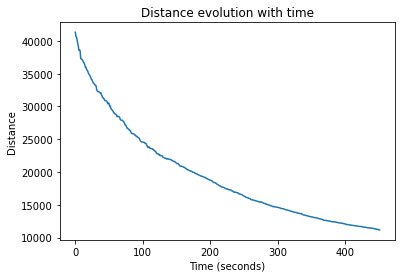

In [152]:
#a distância minima encontrada corresponde à combinação: (300, 30, 0.1, invert, order) , onde fez 546.882770729065 generations

#soma cumulativa do tempo
series=pd.Series(h1_3[1][9])
cumsum=series.cumsum()
plt.plot(cumsum, h1_3[1][8])
plt.xlabel('Time (seconds)')
plt.ylabel('Distance')
plt.title('Distance evolution with time')

Text(0.5, 1.0, 'Distance evolution with generations')

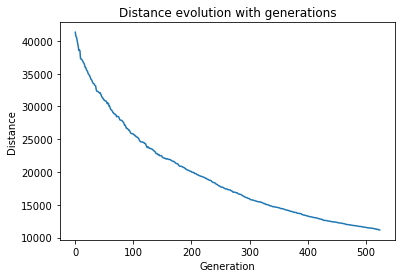

In [155]:
plt.plot(h1_3[1][8])
plt.ylabel('Distance')
plt.xlabel('Generation')
plt.title('Distance evolution with generations')

## Problema 1 - Análise por tipo de hyper-parâmetro

### Taxa de Mutação
Os valores para os restantes hyper-parametros são aqueles que obtiveram o melhor resultado ( distância mínima ).

In [233]:
df=np.asarray(h1_3)

C:\Users\Filipa\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [234]:
###mutação 0.01
mt1=df[np.where((df[:,2] == 0.01) * df[:,0] == 300 )][0]
###mutação 0.1
mt2=df[np.where((df[:,2] == 0.1) * df[:,0] == 300 )][0]
###mutação 0.2
mt3=df[np.where((df[:,2] == 0.2) * df[:,0] == 300 )][0]
###mutação 0.3
mt4=df[np.where((df[:,2] == 0.3) * df[:,0] == 300 )][0]

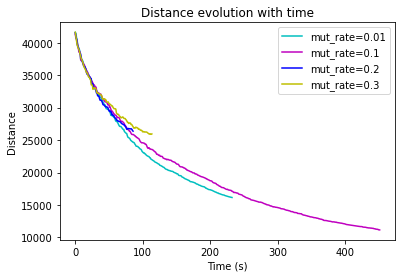

In [235]:

#soma cumulativa do tempo
series=pd.Series(mt1[9])
cumsum1=series.cumsum()
series=pd.Series(mt2[9])
cumsum2=series.cumsum()
series=pd.Series(mt3[9])
cumsum3=series.cumsum()
series=pd.Series(mt4[9])
cumsum4=series.cumsum()

# Plotting both the curves simultaneously
plt.plot(cumsum1, mt1[8], color='c', label='mut_rate=0.01')
plt.plot(cumsum2, mt2[8], color='m', label='mut_rate=0.1')
plt.plot(cumsum3, mt3[8], color='b', label='mut_rate=0.2')
plt.plot(cumsum4, mt4[8], color='y', label='mut_rate=0.3')


plt.ylabel('Distance')
plt.xlabel('Time (s)')
plt.title('Distance evolution with time')
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

### Population size
Os valores para os restantes hyper-parametros são aqueles que obtiveram o melhor resultado ( distância mínima ).

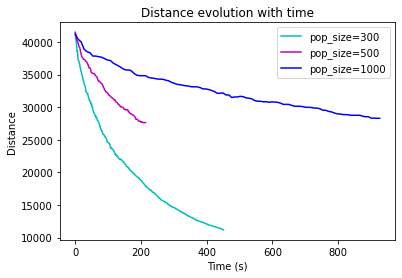

In [201]:
###population 300
pop1=df[np.where((df[:,2] == 0.1) * df[:,0] == 300 )][0]
###population 500
pop2=df[np.where((df[:,2] == 0.1) * df[:,0] == 500 )][0]
###population 1000
pop3=df[np.where((df[:,2] == 0.1) * df[:,0] == 1000 )][0]


#soma cumulativa do tempo
series=pd.Series(pop1[9])
cumsum1=series.cumsum()
series=pd.Series(pop2[9])
cumsum2=series.cumsum()
series=pd.Series(pop3[9])
cumsum3=series.cumsum()

# Plotting both the curves simultaneously
plt.plot(cumsum1, pop1[8], color='c', label='pop_size=300')
plt.plot(cumsum2, pop2[8], color='m', label='pop_size=500')
plt.plot(cumsum3, pop3[8], color='b', label='pop_size=1000')


plt.ylabel('Distance')
plt.xlabel('Time (s)')
plt.title('Distance evolution with time')
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

### Elite size
Os valores para os restantes hyper-parametros são aqueles que obtiveram o melhor resultado ( distância mínima ).

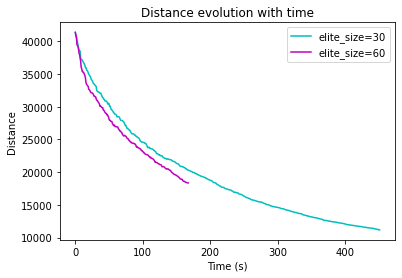

In [202]:
###mutação 0.01
el1=df[np.where((df[:,2] == 0.1) * df[:,1] == 30 )][0]
el2=df[np.where((df[:,2] == 0.1) * df[:,1] == 60 )][0]

#soma cumulativa do tempo
series=pd.Series(el1[9])
cumsum1=series.cumsum()
series=pd.Series(el2[9])
cumsum2=series.cumsum()

# Plotting both the curves simultaneously
plt.plot(cumsum1, el1[8], color='c', label='elite_size=30')
plt.plot(cumsum2, el2[8], color='m', label='elite_size=60')



plt.ylabel('Distance')
plt.xlabel('Time (s)')
plt.title('Distance evolution with time')
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

# Problema 2 - Análise

In [222]:
#distância mínima encontrada
min(h1_4, key=lambda x: x[6])[6]

13715.6

Text(0.5, 1.0, 'Distance evolution with time')

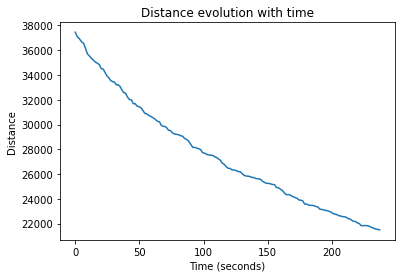

In [205]:
#a distância minima encontrada corresponde à combinação: (300, 30, 0.01, disp, order) , onde fez 807 generations
#soma cumulativa do tempo
series=pd.Series(h1_4[0][9])
cumsum=series.cumsum()
plt.plot(cumsum, h1_4[0][8])
plt.xlabel('Time (seconds)')
plt.ylabel('Distance')
plt.title('Distance evolution with time')

## Problema 2 - Análise por tipo de hyper-parâmetro

### Taxa de Mutação
Os valores para os restantes hyper-parametros são aqueles que obtiveram o melhor resultado ( distância mínima ).

In [213]:
df=np.asarray(h1_4)

C:\Users\Filipa\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [219]:
###mutação 0.01
muut1=df[np.where((df[:,2] == 0.01) * df[:,0] == 300 )][0]
###mutação 0.1
muut2=df[np.where((df[:,2] == 0.1) * df[:,0] == 300 )][0]

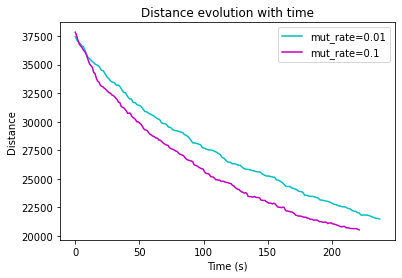

In [220]:

#soma cumulativa do tempo
series=pd.Series(muut1[9])
cumsum1=series.cumsum()
series=pd.Series(muut2[9])
cumsum2=series.cumsum()


# Plotting both the curves simultaneously
plt.plot(cumsum1, muut1[8], color='c', label='mut_rate=0.01')
plt.plot(cumsum2, muut2[8], color='m', label='mut_rate=0.1')



plt.ylabel('Distance')
plt.xlabel('Time (s)')
plt.title('Distance evolution with time')
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

### Population size
Os valores para os restantes hyper-parametros são aqueles que obtiveram o melhor resultado ( distância mínima ).

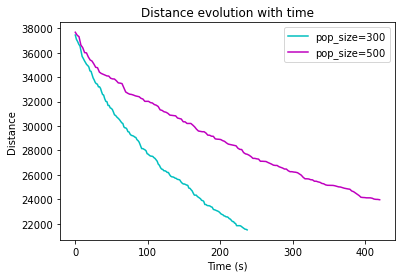

In [229]:
###population 300
pop1=df[np.where((df[:,2] == 0.01) * df[:,0] == 300 )][0]
###population 500
pop2=df[np.where((df[:,2] == 0.01) * df[:,0] == 500 )][0]


#soma cumulativa do tempo
series=pd.Series(pop1[9])
cumsum1=series.cumsum()
series=pd.Series(pop2[9])
cumsum2=series.cumsum()

# Plotting both the curves simultaneously
plt.plot(cumsum1, pop1[8], color='c', label='pop_size=300')
plt.plot(cumsum2, pop2[8], color='m', label='pop_size=500')


plt.ylabel('Distance')
plt.xlabel('Time (s)')
plt.title('Distance evolution with time')
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()